In this tutorial you will learn the following:

1.   Basics of audio processing (load signal, compute and visualize features)
2.   Extract initial pseudo features to train a self-supervised model
- Create necessary train and valid files in .tsv (tab seperated values) format (**STEP 1**)
- Generate pseudo features using a standard python library (**STEP 2**)
- Train and fit a K-Means model on the generated pseudo features to extract pseudo labels (**STEP 3 and STEP 4**)
- Visualize the pseudo labels, cluster centers using several visualization plots (**STEP 4**)
- Once you have the pseudo labels, the model now learns in a self-supervised (SSL) manner and training can be performed (NOT COVERED HERE)
- Worth noting that we won't be using any ground-truth labels instead we can train any self-supervised model using the generated pseudo features and labels

3. Inference on a pre-trained SSL model ([link HuBERT](https://arxiv.org/pdf/2106.07447.pdf)) where feature extraction (**STEP 5**) and label extraction (**STEP 6**) are covered in-depth (Model taken from HuggingFace)

4. Visualize pseudo initialized labels and their SSL pretrained labels (**STEP 7**)
With this procedure, you can extract SSL representation of any given audio data and use it for down-stream tasks such as audio reconstruction [audio resynthesis](https://github.com/facebookresearch/speech-resynthesis)





In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# install necessary packages
!pip install soundfile
!pip install pydub
!pip install transformers datasets torch jupyterlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.1/375.1 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#import necessary packages
import os
import shutil
import requests
import zipfile
import soundfile as sf
import glob
import random
import torch
import tqdm
import torchaudio
import wave
from pydub.utils import mediainfo
import librosa
from IPython.display import Audio

import numpy as np
from sklearn.cluster import MiniBatchKMeans
import joblib
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from transformers import AutoProcessor, AutoModel, HubertModel, HubertPreTrainedModel, Wav2Vec2FeatureExtractor, AutoConfig

In [4]:
# function to download a toy dataset

def download_folder_from_drive(folder_id, output_path):
    # Create a temporary directory to store the downloaded files
    temp_dir = '/content/temp_folder'
    os.makedirs(temp_dir, exist_ok=True)

    # Download the folder as a zip file
    url = f'https://drive.google.com/uc?id={folder_id}&export=download'
    response = requests.get(url, stream=True)

    # Save the zip file
    zip_file_path = os.path.join(temp_dir, 'folder.zip')
    with open(zip_file_path, 'wb') as f:
        shutil.copyfileobj(response.raw, f)

    # Extract the contents of the zip file to the output path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

    # Clean up the temporary directory and zip file
    shutil.rmtree(temp_dir)

# Provide the folder ID and output path
folder_id = '1SpYzmro6u6npX61UPXOKrn-wGYtqe30A'
output_path = '/content/SSL'

# Call the function to download the folder
download_folder_from_drive(folder_id, output_path)

# dataset available at following path
output_path = '/content/SSL/SSL'
data_path = os.path.join(output_path, 'LJSpeech_small')

In [5]:
os.listdir(output_path)

['LJSpeech_small', '.DS_Store']

In [6]:
import sys
sys.path.append(output_path)

**Let's clear some basics**

In [7]:
# Path to the audio file
audio_file = os.path.join(data_path,'en_ljspeech_LJ001_0001.wav')

# read an audio file
waveform, sample_rate = librosa.load(os.path.join(data_path,'en_ljspeech_LJ001_0001.wav'))

# Play audio
Audio(waveform, rate=sample_rate)

# Open the audio file using the wave module
with wave.open(audio_file, 'rb') as audio:
    # Get the audio properties
    sample_width = audio.getsampwidth()
    channels = audio.getnchannels()
    frame_rate = audio.getframerate()
    num_frames = audio.getnframes()
    compression_type = audio.getcomptype()
    compression_name = audio.getcompname()

# Use pydub's mediainfo function to get additional information
audio_info = mediainfo(audio_file)

# Extract the bit rate and encoding information
bit_rate = audio_info['bit_rate']
encoding = audio_info['codec_name']

# Print the obtained information

# sample width refers to the number of bits used to represent the amplitude of each sample in the audio signal. It determines the range and precision of the digital values that can be used to represent the audio data.
print("Sample width (bytes per sample):", sample_width)

# channels refer to the independent paths through which audio signals are transmitted or recorded.
print("Number of channels:", channels)

# frame rate refers to the number of audio frames processed per unit of time.  It indicates how many times the audio signal is sampled per second.
print("Frame rate (samples per second):", frame_rate)

# num_frames refers to the total number of frames in an audio signal. num_frames = duration * sample_rate
# For example, let's consider a stereo audio file with a duration of 10 seconds and a sample rate of 44.1 kHz (44,100 samples per second).
# To calculate the num_frames, we can use the formula:
# num_frames = 10 * 44100 = 441,000 frames
# This means that the audio file contains a total of 441,000 frames.
print("Number of frames:", num_frames)

# compression is employed to minimize storage space, facilitate faster transmission over networks, and enable efficient playback on devices with limited resources.
print("Compression type:", compression_type)

# The compression_name refers to the name or label assigned to the specific compression algorithm or format used for audio compression.
# For example, if the compression_type is "FLAC" (Free Lossless Audio Codec), the compression_name might provide more specific information such as "FLAC 1.3.3" or "FLAC - Level 5."
# Similarly, for lossy compression formats like MP3, the compression_name might indicate the version of the MP3 encoding used, such as "MP3 - LAME 3.99.5."
print("Compression name:", compression_name)

# Bit rate represents the rate at which bits are used to encode or represent the audio data. It measures the amount of data used to represent one second of audio.
print("Bit rate:", bit_rate)

# Encoding refers to the process of converting analog audio signals into a digital format that can be stored, transmitted, or processed by computers and other digital devices.
print("Encoding:", encoding)

Sample width (bytes per sample): 2
Number of channels: 1
Frame rate (samples per second): 16000
Number of frames: 154480
Compression type: NONE
Compression name: not compressed
Bit rate: 256036
Encoding: pcm_s16le


**Feature representation of an audio signal:
**

*   Mel spectrogram: A Mel spectrogram represents the power spectrum of an audio signal in the Mel frequency domain. It provides a visual representation of how the energy of different frequency components of the audio signal varies over time. The y-axis represents the frequency bins in the Mel scale, and the x-axis represents time.

Let's visualize a Mel-spectrogram of an audio signal

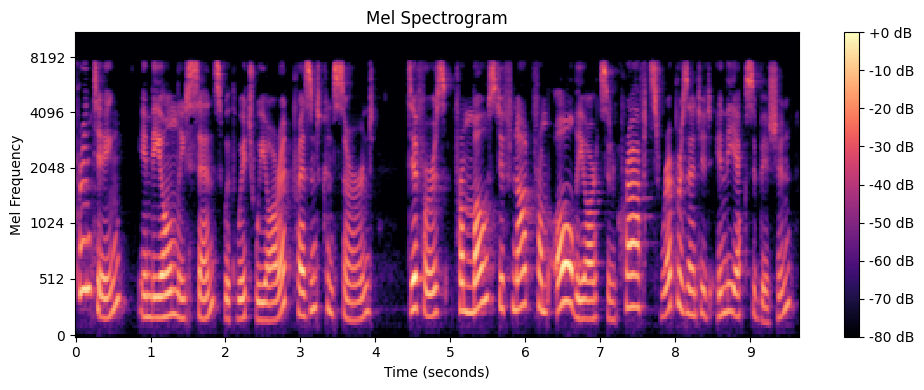

In [8]:
# The librosa.load() function is used to load the audio waveform from the file specified by os.path.join(data_path,'en_ljspeech_LJ001_0001.wav').
waveform, sample_rate = librosa.load(os.path.join(data_path,'en_ljspeech_LJ001_0001.wav'))
from matplotlib.animation import FuncAnimation

# The librosa.feature.melspectrogram() function is used to compute the Mel spectrogram of the waveform.
# The y parameter is set to the waveform, sr is set to the sample rate, n_fft is the length of the FFT window, hop_length is the hop length between consecutive frames, and n_mels is the number of Mel frequency bins.
# The computed Mel spectrogram is stored in the mel_spectrogram variable.
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)

# The librosa.power_to_db() function is used to convert the Mel spectrogram to the dB scale.
# The mel_spectrogram is passed as input, and ref=np.max sets the reference power for the conversion.
# The resulting Mel spectrogram in the dB scale is stored in the mel_spectrogram_db variable.
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(10, 4))

# The librosa.display.specshow() function is used to display the Mel spectrogram on the plot.
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Mel Frequency')
plt.tight_layout()

# Display plot
plt.show()

# Play audio
Audio(waveform, rate=sample_rate)


**Modified Feature Representation of an Audio Signal**


*   MFCC: MFCC, are a compressed representation derived from the Mel spectrogram. MFCC is a compressed representation of the Mel spectrogram. It typically reduces the dimensionality of the spectrogram by keeping a smaller number of coefficients (e.g., 13 coefficients). Each MFCC coefficient captures certain characteristics of the audio signal, such as the shape of the power spectrum in specific frequency bands.



In [9]:
# This line reads the audio file located at data_path/en_ljspeech_LJ001_0001.wav using sf.read() from the soundfile library. The resulting waveform data is stored in the wav variable, and the sample rate of the audio is stored in the sample_rate variable. The dtype="float32" argument specifies the desired data type of the waveform as 32-bit floating-point values. The always_2d=True argument ensures that the waveform data is always returned as a two-dimensional array, even if it has a single channel.
wav, sample_rate = sf.read(
      os.path.join(data_path,'en_ljspeech_LJ001_0001.wav'), dtype="float32", always_2d=True
  )

# This line transposes the waveform data stored in wav to ensure that the channels are represented along the first axis and the samples along the second axis. This is done by taking the transpose of the wav array using .T.
x = wav.T

# These lines convert the transposed waveform data x from a NumPy array to a PyTorch tensor using torch.from_numpy(x). The float() method is called to ensure the tensor has a floating-point data type. The .view(1, -1) operation reshapes the tensor to have a batch dimension of 1 and an inferred size along the second dimension, maintaining the original number of samples.
with torch.no_grad():
  x = torch.from_numpy(x).float()
  x = x.view(1, -1)

# This line computes the Mel-frequency cepstral coefficients (MFCCs) using the torchaudio.compliance.kaldi.mfcc() function. The function takes the waveform data x, the sample frequency sample_rate, and the use_energy=False argument. The resulting MFCCs are stored in the mfccs variable.
mfccs = torchaudio.compliance.kaldi.mfcc(
              waveform=x,
              sample_frequency=sample_rate,
              use_energy=False,
          )

# This line prints a message that describes the shape of the MFCCs obtained from the audio file. The shape of mfccs is a tuple representing the dimensions of the MFCCs array. The message uses f-string formatting to include the shape and its components in the printed output.
print(f"A typical features of an audio has shape {mfccs.shape}, where {mfccs.shape[0]} represents number of frames and {mfccs.shape[1]} represents dimension.")


A typical features of an audio has shape torch.Size([964, 13]), where 964 represents number of frames and 13 represents dimension.


**STEP 1: Create train.tsv and valid.tsv files**
- each tsv file has file name and number of samples

In [10]:
# This line assigns the real path of the data_path to the dir_path variable. The os.path.realpath() function resolves any symbolic links and returns the absolute path of the directory.
dir_path = os.path.realpath(data_path)
ext = 'wav'
search_path = os.path.join(dir_path, "**/*." + ext)

# This line sets the valid_percent variable to 0.1, representing the percentage of files to be allocated for validation. In this case, 10% of the files will be used for validation, while the remaining 90% will be used for training.
valid_percent = 0.1

# These lines set the random seed (seed) to 42 and create a random number generator (rand) using random.Random(seed).
seed = 42
rand = random.Random(seed)

# create a folder under which all the processing will happen
os.makedirs(os.path.join(output_path, "Initialization"),exist_ok=True)

# This line opens a file valid_f for writing if valid_percent is greater than 0.
# The file is created at "output_path/Initialization/valid.tsv". If valid_percent is 0 or less, valid_f is set to None.
valid_f = (
        open(os.path.join(output_path, "Initialization/valid.tsv"), "w")
        if valid_percent > 0
        else None
    )

# This code block opens a file train_f for writing at "output_path/Initialization/train.tsv". It then iterates over the files matching the search_path
with open(os.path.join(output_path, "Initialization/train.tsv"), "w") as train_f:
  print(dir_path, file=train_f)
  if valid_f is not None:
      print(dir_path, file=valid_f)

  for fname in glob.iglob(search_path, recursive=True):
    # The real path of each file (fname) is obtained using os.path.realpath().
    file_path = os.path.realpath(fname)

    # The number of frames in the file is obtained using sf.info(fname).frames.
    frames = sf.info(fname).frames

    # The destination file (dest) is determined based on whether a random value from rand.random() is greater than valid_percent.
    # If it is, the destination is train_f; otherwise, it is valid_f.
    dest = train_f if rand.random() > valid_percent else valid_f

    # The relative file path (os.path.relpath(file_path, dir_path)) and the number of frames are printed to the destination file.
    print(
        "{}\t{}".format(os.path.relpath(file_path, dir_path), frames), file=dest
    )

# This line closes the valid_f file if it was opened, ensuring proper cleanup.
if valid_f is not None:
  valid_f.close()

# These lines print a message describing the format of the .tsv file and display the first five lines of the "output_path/Initialization/train.tsv" file.
# It demonstrates how the file contains two columns, where the first column represents the file name and the second column indicates the number of samples.
print('This is how .tsv file looks like: \n', 'the first column is file name and second column suggest number of samples')
print('\n'.join([line.rstrip() for line in open(os.path.join(output_path, "Initialization/train.tsv"))][:5]))

This is how .tsv file looks like: 
 the first column is file name and second column suggest number of samples
/content/SSL/SSL/LJSpeech_small
en_ljspeech_LJ001_0068.wav	145935
en_ljspeech_LJ001_0059.wav	145006
en_ljspeech_LJ001_0038.wav	155594
en_ljspeech_LJ001_0005.wav	129774


**STEP 2: Generate Pseudo features**

In [11]:
# define iterator and number of files to process
split = "train"

# Path to store generated pseudo features
feat_dir = os.path.join(output_path, "Initialization/Pseudo features")
os.makedirs(feat_dir,exist_ok=True)

# path to store generated pseudo features and their number of frames
feat_path = f"{feat_dir}/{split}.npy"
leng_path = f"{feat_dir}/{split}.len"

# the code reads the contents of the TSV (Tab-Separated Values) file specified by "Initialization/train.tsv" (assuming split is "train"). The file is opened in read mode using open().
with open(os.path.join(output_path, "Initialization",split+".tsv"), "r") as f:

    # The first line of the file is read and stored in the root variable after removing any trailing whitespace (rstrip() is used to remove the newline character).
    root = f.readline().rstrip()

    # The remaining lines of the file are read and stored in the lines list, with trailing whitespace removed for each line.
    lines = [line.rstrip() for line in f]

    # The iterate() function is defined to yield tuples containing the file paths and corresponding sample sizes.
    # It iterates over the lines list and splits each line using the tab character ("\t") as the delimiter.
    def iterate():
        for line in lines:
            subpath, nsample = line.split("\t")

            # The file path is constructed by concatenating root and subpath, and the sample size is converted to an integer using int(nsample).
            # The yield statement is used to yield each file path and sample size as a tuple.
            yield f"{root}/{subpath}", int(nsample)

    # The num variable is assigned the length of the lines list, representing the number of files to be processed.
    num = len(lines)

# Finally, the iterate() function is called and assigned to the iterator variable.
iterator = iterate()

# initialize list to store pseudo features
feat_f = []

# store length of each feature as well
with open(leng_path, "w") as leng_f:

  # iterate over all data
  for path, nsample in tqdm.tqdm(iterator, total=num):

    basename = os.path.basename(path).split('.')[0]

    # The audio file is read using sf.read() and the waveform data wav and sample rate sample_rate are obtained.
    wav, sample_rate = sf.read(
          path, dtype="float32", always_2d=True
      )

    # The waveform data wav is transposed to match the shape expected by torchaudio.
    x = wav.T

    # The waveform data x is converted to a PyTorch tensor, ensuring it's of type float, and reshaped to have a batch dimension of 1 using .view(1, -1).
    with torch.no_grad():
      x = torch.from_numpy(x).float()
      x = x.view(1, -1)

    # The actual pseudo features are extracted using torchaudio.compliance.kaldi.mfcc().
    # It takes the waveform data x, sample rate sample_rate, and use_energy=False as arguments.
    # The resulting pseudo features mfccs are transposed to have the shape [time, feature].
    mfccs = torchaudio.compliance.kaldi.mfcc(
                  waveform=x,
                  sample_frequency=sample_rate,
                  use_energy=False,
              )
    mfccs = mfccs.transpose(0, 1)

    # Additional pseudo features are computed by calculating deltas and double-deltas using torchaudio.functional.compute_deltas().
    deltas = torchaudio.functional.compute_deltas(mfccs)
    ddeltas = torchaudio.functional.compute_deltas(deltas)

    # All the computed pseudo features are concatenated along the feature dimension using torch.cat(). The resulting tensor concat has the shape [time, total_features].
    concat = torch.cat([mfccs, deltas, ddeltas], dim=0)

    # The tensor concat is transposed to have the shape [total_features, time] and made contiguous using .transpose(0, 1).contiguous().
    feat = concat.transpose(0, 1).contiguous()

    # The pseudo features feat are appended to the feat_f list after converting them to a NumPy array with .cpu().numpy().
    feat_f.append(feat.cpu().numpy())

    print(f"Extracted Pseudo features shape {feat.cpu().numpy().shape}")

    print(f"Storing Pseudo features at {os.path.join(feat_dir,basename+'.npy')} \n")

    # The features are saved to a numpy file with the basename as the file name.
    np.save(os.path.join(feat_dir,basename+'.npy'), feat.cpu().numpy())

    # The length of the feat tensor (number of frames) is written to the file using leng_f.write(f"{len(feat)}\n").
    leng_f.write(f"{len(feat)}\n")

# feat_f list is concatenated along the first axis resulting in a single NumPy array feat_f. This array represents all the features of all files combined
feat_f = np.concatenate(feat_f,axis=0)

# store all features of all files in a single file
np.save(feat_path, feat_f)

  1%|          | 1/87 [00:00<00:08,  9.65it/s]

Extracted Pseudo features shape (910, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0068.npy 



  5%|▍         | 4/87 [00:00<00:04, 19.01it/s]

Extracted Pseudo features shape (904, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0059.npy 

Extracted Pseudo features shape (970, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0038.npy 

Extracted Pseudo features shape (809, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0005.npy 

Extracted Pseudo features shape (465, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0020.npy 

Extracted Pseudo features shape (784, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0024.npy 



  8%|▊         | 7/87 [00:00<00:03, 22.69it/s]

Extracted Pseudo features shape (706, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0032.npy 

Extracted Pseudo features shape (688, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0082.npy 



 13%|█▎        | 11/87 [00:00<00:02, 26.07it/s]

Extracted Pseudo features shape (784, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0031.npy 

Extracted Pseudo features shape (770, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0049.npy 

Extracted Pseudo features shape (535, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0052.npy 

Extracted Pseudo features shape (256, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0013.npy 

Extracted Pseudo features shape (424, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0037.npy 

Extracted Pseudo features shape (440, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0079.npy 

Extracted Pseudo features shape (822, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 24%|██▍       | 21/87 [00:00<00:01, 34.89it/s]

Extracted Pseudo features shape (676, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0060.npy 

Extracted Pseudo features shape (348, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0061.npy 

Extracted Pseudo features shape (194, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0078.npy 

Extracted Pseudo features shape (453, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0081.npy 

Extracted Pseudo features shape (885, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0025.npy 

Extracted Pseudo features shape (591, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0028.npy 

Extracted Pseudo features shape (706, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 34%|███▍      | 30/87 [00:00<00:01, 38.02it/s]

Extracted Pseudo features shape (463, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0098.npy 

Extracted Pseudo features shape (418, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0095.npy 

Extracted Pseudo features shape (530, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0029.npy 

Extracted Pseudo features shape (512, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0004.npy 

Extracted Pseudo features shape (664, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0091.npy 

Extracted Pseudo features shape (922, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0015.npy 

Extracted Pseudo features shape (301, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 47%|████▋     | 41/87 [00:01<00:01, 43.38it/s]

Extracted Pseudo features shape (690, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0030.npy 

Extracted Pseudo features shape (796, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0092.npy 

Extracted Pseudo features shape (176, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0008.npy 

Extracted Pseudo features shape (753, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0009.npy 

Extracted Pseudo features shape (746, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0018.npy 

Extracted Pseudo features shape (777, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0070.npy 

Extracted Pseudo features shape (801, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 53%|█████▎    | 46/87 [00:01<00:01, 37.47it/s]

Extracted Pseudo features shape (757, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0040.npy 

Extracted Pseudo features shape (837, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0007.npy 

Extracted Pseudo features shape (857, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0100.npy 

Extracted Pseudo features shape (607, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0026.npy 

Extracted Pseudo features shape (957, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0066.npy 

Extracted Pseudo features shape (325, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0090.npy 

Extracted Pseudo features shape (865, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 67%|██████▋   | 58/87 [00:01<00:00, 45.82it/s]

Extracted Pseudo features shape (432, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0054.npy 

Extracted Pseudo features shape (519, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0062.npy 

Extracted Pseudo features shape (962, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0027.npy 

Extracted Pseudo features shape (707, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0073.npy 

Extracted Pseudo features shape (676, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0086.npy 

Extracted Pseudo features shape (388, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0043.npy 

Extracted Pseudo features shape (830, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 72%|███████▏  | 63/87 [00:01<00:00, 44.34it/s]

Extracted Pseudo features shape (648, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0072.npy 

Extracted Pseudo features shape (700, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0017.npy 

Extracted Pseudo features shape (859, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0021.npy 

Extracted Pseudo features shape (880, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0010.npy 

Extracted Pseudo features shape (586, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0064.npy 

Extracted Pseudo features shape (419, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0084.npy 



 78%|███████▊  | 68/87 [00:01<00:00, 39.25it/s]

Extracted Pseudo features shape (555, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0069.npy 



 84%|████████▍ | 73/87 [00:02<00:00, 38.33it/s]

Extracted Pseudo features shape (822, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0012.npy 

Extracted Pseudo features shape (649, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0074.npy 

Extracted Pseudo features shape (537, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0080.npy 

Extracted Pseudo features shape (484, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0051.npy 

Extracted Pseudo features shape (934, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0077.npy 

Extracted Pseudo features shape (504, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0035.npy 

Extracted Pseudo features shape (665, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

 97%|█████████▋| 84/87 [00:02<00:00, 44.13it/s]

Extracted Pseudo features shape (873, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0088.npy 

Extracted Pseudo features shape (679, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0075.npy 

Extracted Pseudo features shape (640, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0019.npy 

Extracted Pseudo features shape (965, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0096.npy 

Extracted Pseudo features shape (907, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0034.npy 

Extracted Pseudo features shape (710, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0093.npy 

Extracted Pseudo features shape (964, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljsp

100%|██████████| 87/87 [00:02<00:00, 37.73it/s]

Extracted Pseudo features shape (548, 39)
Storing Pseudo features at /content/SSL/SSL/Initialization/Pseudo features/en_ljspeech_LJ001_0056.npy 



**STEP 3: Train a K-Means model using the pseudo features extracted from STEP 2**

In [12]:
# Learn a K-means model

# This line loads the pseudo features extracted from a previous step.
# The features are stored in the feat_path file, and np.load() is used to load them into the feat variable.
# mmap_mode="r" enables memory-mapping of the features for efficient memory usage.
feat = np.load(feat_path, mmap_mode="r")

# This line sets the number of clusters for the K-means model. The variable n_clusters is assigned the value 100, representing the desired number of clusters.
n_clusters = 100

# some initialization variables
init = "k-means++" # Specifies the initialization method for cluster centers. "k-means++" is used, which is a smart initialization technique.
max_iter = 100 # Defines the maximum number of iterations for the K-means algorithm.
batch_size = 10000 # Determines the size of the mini-batches used during each iteration.
tol = 0.0 # Specifies the tolerance for convergence. A value of 0.0 indicates strict convergence.
max_no_improvement = 100 # Determines the maximum number of consecutive iterations without improvement in clustering.
n_init = 20 #  Specifies the number of times the algorithm will be run with different centroid seeds.
reassignment_ratio = 0.0 # Specifies the ratio of reassignment during each iteration. A value of 0.0 disables reassignment.

# This line constructs the file path where the K-means model will be stored.
# The km_path variable is assigned the path by joining the output_path and the folder/file name 'Initialization/km.bin'.
km_path = os.path.join(output_path,'Initialization/km.bin')

# call K-Means models from scipy
km_model = MiniBatchKMeans(
        n_clusters=n_clusters,
        init=init,
        max_iter=max_iter,
        batch_size=batch_size,
        tol=tol,
        max_no_improvement=max_no_improvement,
        n_init=n_init,
        reassignment_ratio=reassignment_ratio,
    )

# fit K-Means on pseudo features extracted from STEP 2
km_model.fit(feat)

# store K-Means model
joblib.dump(km_model, km_path)

['/content/SSL/SSL/Initialization/km.bin']

**STEP 4: Extract Pseudo labels from trained K-means model**

100%|██████████| 87/87 [00:00<00:00, 405.22it/s]


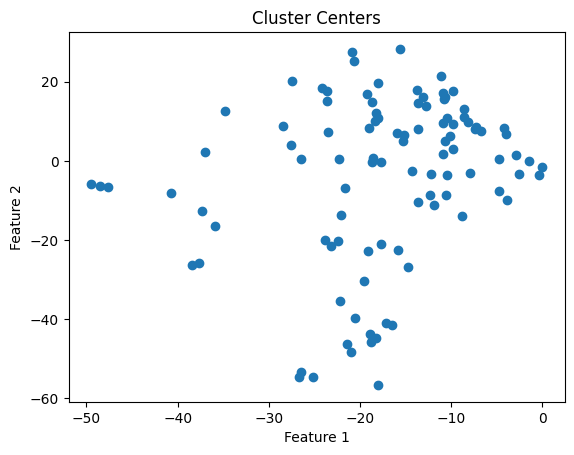

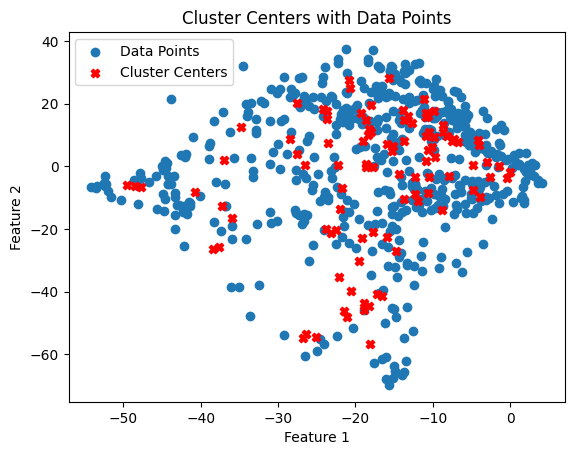

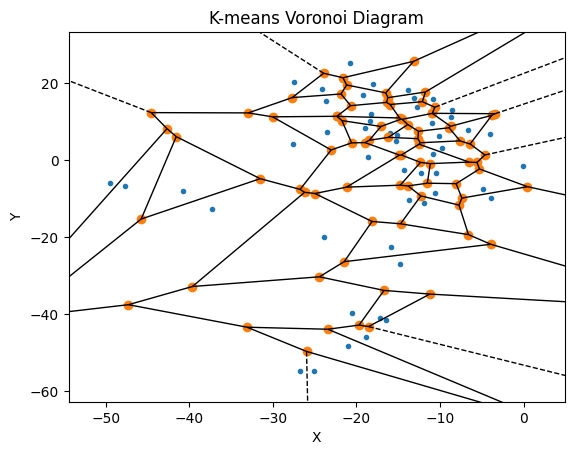

In [13]:
# Mention directory to store extracted pseudo labels
lab_dir = os.path.join(output_path, "Initialization/Pseudo labels")
os.makedirs(lab_dir, exist_ok=True)

# path where extracted pseudo labels will be stored
lab_path = f"{lab_dir}/{split}.km"

# Get the pseudo features extracted from STEP 2
feat_path = f"{feat_dir}/{split}.npy"
leng_path = f"{feat_dir}/{split}.len"

# This section reads the lengths of the pseudo features from the file specified by leng_path.
# It opens the file and reads each line, converting it to an integer and storing it in the lengs list.
# The offsets list is created by calculating the cumulative sum of the lengs list, excluding the last element, with an initial offset of 0.
with open(leng_path, "r") as f:
    lengs = [int(line.rstrip()) for line in f]
    offsets = [0] + np.cumsum(lengs[:-1]).tolist()

# This code defines an iterator function iterate() to iterate over the pseudo features.
# It loads the pseudo features from the file specified by feat_path using np.load(), with mmap_mode="r" to read the file in a memory-mapped manner.
# The function yields slices of the features based on the offsets and lengths calculated earlier.
# The num variable stores the length of the lengs list, and iterator is assigned the result of calling iterate().
def iterate():
    feat = np.load(feat_path, mmap_mode="r")
    assert feat.shape[0] == (offsets[-1] + lengs[-1])
    for offset, leng in zip(offsets, lengs):
        yield feat[offset: offset + leng]
    return iterate

num = len(lengs)
iterator = iterate()

# define a K-Means function to extract pseudo labels
def apply_kmeans(km_path, x):

    # The function loads the K-means model using joblib.load().
    km_model = joblib.load(km_path)

    # The cluster centers are stored in C_np as a transposed NumPy array, which is obtained from the loaded K-means model.
    C_np = km_model.cluster_centers_.transpose()

    # Cnorm_np calculates the squared norm of the cluster centers along the 0th axis, keeping the dimensions.
    Cnorm_np = (C_np ** 2).sum(0, keepdims=True)

    # # Convert the cluster centers and Cnorm to PyTorch tensors.
    C = torch.from_numpy(C_np)
    Cnorm = torch.from_numpy(Cnorm_np)

    # Move the tensors to GPU if available.
    if torch.cuda.is_available():
        C = C.cuda()
        Cnorm = Cnorm.cuda()

    # If the input x is a PyTorch tensor, it calculates the distances between x and the cluster centers by squaring x,
    # summing along the second axis, performing matrix multiplication with C, and subtracting Cnorm.
    # The resulting distances are stored in the dist tensor.
    if isinstance(x, torch.Tensor):
        dist = (
            x.pow(2).sum(1, keepdim=True)
            - 2 * torch.matmul(x, C)
            + Cnorm
        )
        # The function returns the indices of the minimum distances (the cluster assignments) and the cluster centers (C_np) as a NumPy array.
        return dist.argmin(dim=1).cpu().numpy(), C_np

    # If the input x is a NumPy array, it calculates the distances in a similar manner as above, but using NumPy operations.
    # The resulting distances are stored in the dist array.
    else:
        dist = (
            (x ** 2).sum(1, keepdims=True)
            - 2 * np.matmul(x, C_np)
            + Cnorm_np
        )
        # The function returns the indices of the minimum distances (the cluster assignments) and the cluster centers (C_np) as a NumPy array.
        return np.argmin(dist, axis=1), C_np

# store cluster labels of each audio file
with open(lab_path, "w") as f:
  for feat in tqdm.tqdm(iterator, total=num):
    cluster_assignments, cluster_centers = apply_kmeans(km_path, feat)
    f.write(" ".join(map(str, cluster_assignments)) + "\n")

# plot_cluster_centers() takes C_np (the cluster centers) as input and plots them as scatter points.
def plot_cluster_centers(C_np): # (39 x 100) : (dimension x cluster)
    plt.scatter(C_np[0,:], C_np[1,:])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Cluster Centers')
    plt.show()

# plot_cluster_centers_with_data() takes C_np (the cluster centers) and data (additional data points) as inputs and plots both the cluster centers and data points.
def plot_cluster_centers_with_data(C_np, data):
    plt.scatter(data[:,0], data[:,1], label='Data Points')
    plt.scatter(C_np[0,:], C_np[1,:], marker='X', color='red', label='Cluster Centers')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Cluster Centers with Data Points')
    plt.legend()
    plt.show()

# lot_kmeans_voronoi_diagram() takes km_path (the path to the K-means model) as input and generates a Voronoi diagram based on the cluster centers.
def plot_kmeans_voronoi_diagram(km_path):
    km_model = joblib.load(km_path)
    C_np = km_model.cluster_centers_

    # Select a subset of cluster centers: 50 clusters and 2 features
    selected_C_np = C_np[:50,:2]

    vor = Voronoi(selected_C_np)
    fig = voronoi_plot_2d(vor)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('K-means Voronoi Diagram')
    plt.show()

# Visualize cluster centers
plot_cluster_centers(cluster_centers)

# Visualize cluster assignments of an example feature
plot_cluster_centers_with_data(cluster_centers, feat)

# This plot generates a Voronoi diagram based on the cluster centers,
# visually dividing the space into regions associated with each cluster center.
plot_kmeans_voronoi_diagram(km_path)

**STEP 5: Extract Self-Supervised features from a pre-trained model**

In [14]:
# pretrained_path: It represents the path where the pre-trained features will be stored.
pretrained_path = os.path.join(output_path,'pretrained')
os.makedirs(pretrained_path,exist_ok=True)

# This folder, located within pretrained_path, is specifically meant to store the extracted HuBERT features from the audio files.
pretrained_features = os.path.join(pretrained_path,'HuBERT_features')
os.makedirs(pretrained_features,exist_ok=True)

# In this part, the code makes use of HuggingFace's from_pretrained() function to download a pre-trained self-supervised model.
# Specifically, the Wav2Vec2FeatureExtractor and HubertModel classes are instantiated with the "facebook/hubert-base-ls960" model name.
# The output_hidden_states=True argument is provided to the HubertModel constructor, enabling the model to output hidden states as well.

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960", output_hidden_states=True)

# Finally, the code prints the configuration of the self-supervised model, indicating the model's architecture and settings.
print(f"The self-supervised model's configuration can be found here {hubert_model}")

The self-supervised model's configuration can be found here HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_co

In [15]:
# layer from which features will be extracted.
extact_feature_from_layer = 5

# feature_store is a list used to store the extracted features.
feature_store = []

# The feature_hook function is defined as a hook to capture the features when the model is run.
def feature_hook(module, input, result):
    feature_store.append(result[0].cpu().detach().numpy())
    return

# hook_handler registers the feature_hook to the desired layer in the model.
hook_handler = hubert_model.encoder.layers[extact_feature_from_layer].register_forward_hook(feature_hook)

# The code iterates over each audio file in the specified directory.
for audio in os.listdir(dir_path):

  print(f"Extracting HuBERT features for {audio}")

  # The audio file name is split to obtain the basename without the extension.
  basename = audio.split('.')[0]

  # The audio file is read using sf.read(), and the sample rate (sr) is obtained.
  audio, sr = sf.read(os.path.join(dir_path,'en_ljspeech_LJ001_0043.wav'))

  # The audio input is processed using the feature_extractor, converting it to a PyTorch tensor.
  processed_input = feature_extractor(audio, return_tensors="pt",sampling_rate=sr).input_values

  # The model is set to evaluation mode, and the forward pass is performed.
  hubert_model.eval()
  with torch.no_grad():
    hubert_model(processed_input)

  print(f"Extracted HuBERT features shape {feature_store[0].squeeze().shape}")

  # The extracted features are stored in pretrained_feats.
  pretrained_feats = feature_store[0].squeeze()

  print(f"Storing HuBERT features at {os.path.join(pretrained_features,basename+'.npy')} \n")

  # The features are saved to a numpy file with the basename as the file name.
  np.save(os.path.join(pretrained_features,basename+'.npy'), pretrained_feats)

# The hook is removed from the model to clean up.
hook_handler.remove()

Extracting HuBERT features for en_ljspeech_LJ001_0068.wav
Extracted HuBERT features shape (194, 768)
Storing HuBERT features at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0068.npy 

Extracting HuBERT features for en_ljspeech_LJ001_0006.wav
Extracted HuBERT features shape (194, 768)
Storing HuBERT features at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0006.npy 

Extracting HuBERT features for en_ljspeech_LJ001_0059.wav
Extracted HuBERT features shape (194, 768)
Storing HuBERT features at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0059.npy 

Extracting HuBERT features for en_ljspeech_LJ001_0038.wav
Extracted HuBERT features shape (194, 768)
Storing HuBERT features at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0038.npy 

Extracting HuBERT features for en_ljspeech_LJ001_0005.wav
Extracted HuBERT features shape (194, 768)
Storing HuBERT features at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0005.n

**STEP 6: Extract Self-Supervised labels from Self-Supervised features using a pre-trained model**

In [16]:
# Extract cluster labels of each extracted HuBERT features

# create a text file where labels will be stored
pretrained_labels = os.path.join(pretrained_path,'HuBERT_labels.txt')

# download one of the available pre-trained K-Means model
!wget -P /content/SSL/SSL/pretrained/ https://dl.fbaipublicfiles.com/textless_nlp/gslm/hubert/km100/km.bin
pretrained_km_path = '/content/SSL/SSL/pretrained/km.bin'

# write self-supervised labels to below file
with open(pretrained_labels, "w") as f:

  # iterate over all self-supervised features extracted from STEP 5
  for afile in os.listdir(pretrained_features):
    print(f"Extracting labels from features stored at {os.path.join(pretrained_features,afile)}")

    # load self-supervised features extracted from STEP 5
    feat = np.load(os.path.join(pretrained_features,afile))

    # apply a pre-trained K-Means model stored at pretrained_km_path
    cluster_assignments, cluster_centers = apply_kmeans(pretrained_km_path, feat)

    # write the labels to the file
    f.write(" ".join(map(str, cluster_assignments)) + "\n")

--2023-07-13 11:31:01--  https://dl.fbaipublicfiles.com/textless_nlp/gslm/hubert/km100/km.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.102, 18.154.144.74, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308469 (301K) [application/octet-stream]
Saving to: ‘/content/SSL/SSL/pretrained/km.bin’

km.bin              100%[===================>] 301.24K  --.-KB/s    in 0.02s   

2023-07-13 11:31:01 (12.1 MB/s) - ‘/content/SSL/SSL/pretrained/km.bin’ saved [308469/308469]

Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0030.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0085.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0012.npy
Extracting labels from features stored a

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.24.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0086.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0043.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0040.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0023.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0050.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0055.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0018.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeech_LJ001_0090.npy
Extracting labels from features stored at /content/SSL/SSL/pretrained/HuBERT_features/en_ljspeec

**STEP 7: Visualize pseudo initialized labels and their SSL pretrainedtrained labels**

Extracted Pseudo features of shape (964, 39) and SSL features of shape (194, 768) 

Extracted 964 Pseudo labels for file en_ljspeech_LJ001_0001 

Extracted 194 SSL labels for file en_ljspeech_LJ001_0001 

Plotting cluster centers from pseudo and pre-trained features


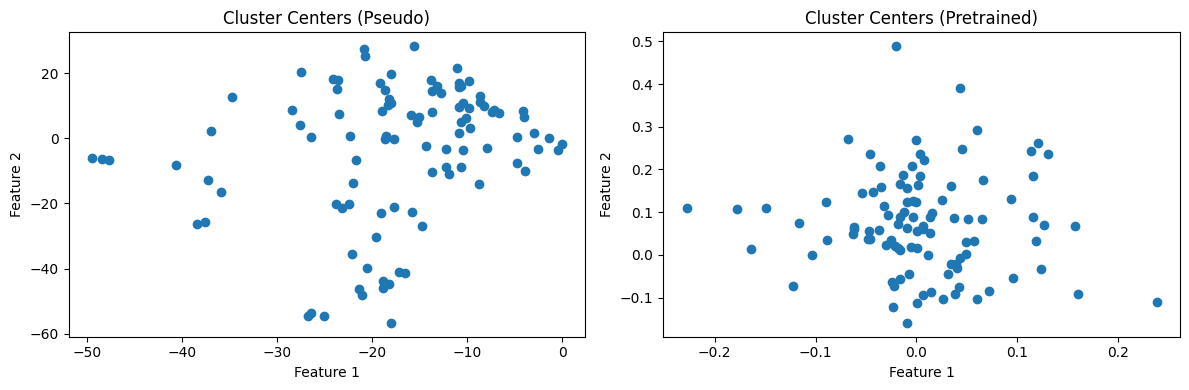

Plotting cluster centers from pseudo and pre-trained features along with data points


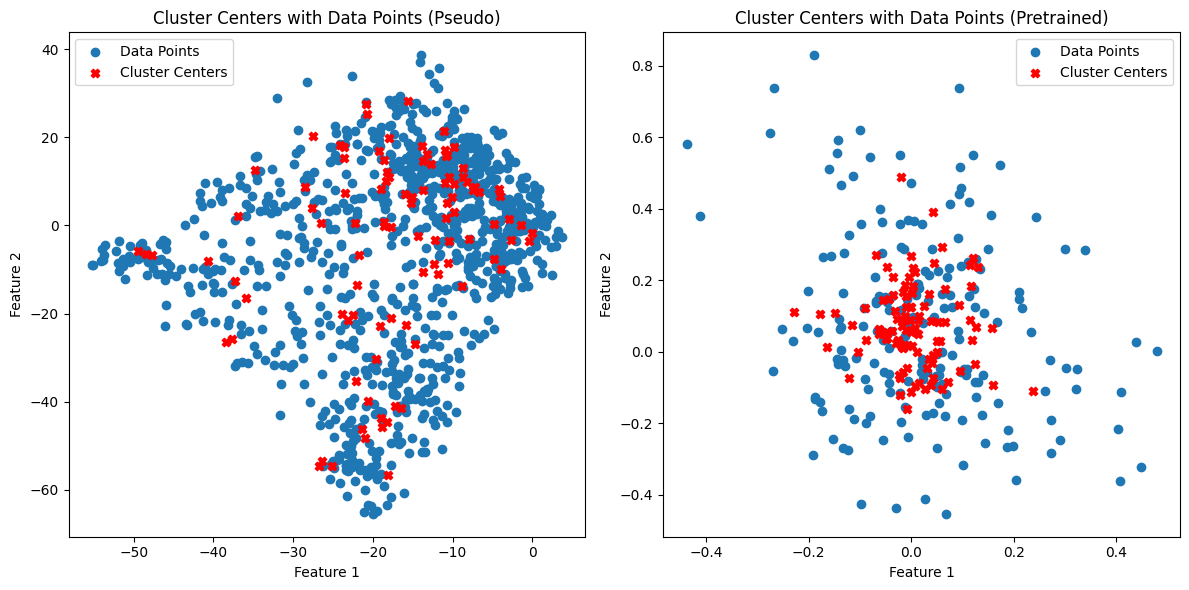

Plotting Voronoi diagram for pseudo and pre-trained labels


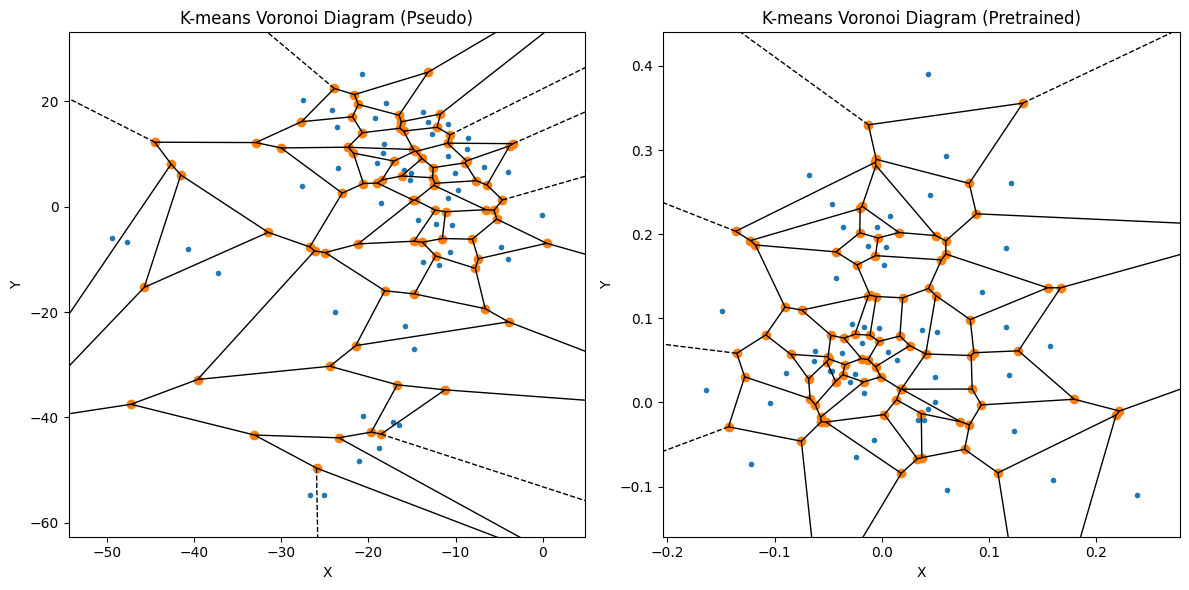

In [17]:
# path where pseudo features are stored
pseudo_features_path = '/content/SSL/SSL/Initialization/Pseudo features'

# path where pseudo K-Means model is stored
pseudo_km_path = '/content/SSL/SSL/Initialization/km.bin'

# path where SSL features are stored
pretrained_features_path = '/content/SSL/SSL/pretrained/HuBERT_features'

# path where SSL K-Means model is stored
pretrained_km_path = '/content/SSL/SSL/pretrained/km.bin'

# take any one example
filename = 'en_ljspeech_LJ001_0001'

# load pseudo features and SSL features
pseudo_features = np.load(os.path.join(pseudo_features_path,filename+'.npy'))
pretrained_features = np.load(os.path.join(pretrained_features_path,filename+'.npy'))
print(f"Extracted Pseudo features of shape {pseudo_features.shape} and SSL features of shape {pretrained_features.shape} \n")

# extract K-Means labels
pseudo_cluster_assignments, pseudo_cluster_centers = apply_kmeans(pseudo_km_path, pseudo_features)
pretrained_cluster_assignments, pretrained_cluster_centers = apply_kmeans(pretrained_km_path, pretrained_features)

print(f"Extracted {len(pseudo_cluster_assignments)} Pseudo labels for file {filename} \n")
print(f"Extracted {len(pretrained_cluster_assignments)} SSL labels for file {filename} \n")


print(f"Plotting cluster centers from pseudo and pre-trained features")
def plot_cluster_centers(C_np1, C_np2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot cluster centers for C_np1
    axes[0].scatter(C_np1[0, :], C_np1[1, :])
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].set_title('Cluster Centers (Pseudo)')

    # Plot cluster centers for C_np2
    axes[1].scatter(C_np2[0, :], C_np2[1, :])
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].set_title('Cluster Centers (Pretrained)')

    plt.tight_layout()
    plt.show()

plot_cluster_centers(pseudo_cluster_centers,pretrained_cluster_centers)

print(f"Plotting cluster centers from pseudo and pre-trained features along with data points")
def plot_cluster_centers_with_data(C_np1, data1, C_np2, data2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot cluster centers and data points for C_np1
    axes[0].scatter(data1[:, 0], data1[:, 1], label='Data Points')
    axes[0].scatter(C_np1[0, :], C_np1[1, :], marker='X', color='red', label='Cluster Centers')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].set_title('Cluster Centers with Data Points (Pseudo)')
    axes[0].legend()

    # Plot cluster centers and data points for C_np2
    axes[1].scatter(data2[:, 0], data2[:, 1], label='Data Points')
    axes[1].scatter(C_np2[0, :], C_np2[1, :], marker='X', color='red', label='Cluster Centers')
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].set_title('Cluster Centers with Data Points (Pretrained)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_cluster_centers_with_data(pseudo_cluster_centers,pseudo_features,pretrained_cluster_centers,pretrained_features)

print(f"Plotting Voronoi diagram for pseudo and pre-trained labels")
def plot_kmeans_voronoi_diagram(pseudo_km_path, pretrained_km_path):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Pseudo Voronoi diagram
    pseudo_km_model = joblib.load(pseudo_km_path)
    pseudo_C_np = pseudo_km_model.cluster_centers_
    pseudo_selected_C_np = pseudo_C_np[:50, :2]
    pseudo_vor = Voronoi(pseudo_selected_C_np)
    ax1 = axes[0]
    voronoi_plot_2d(pseudo_vor, ax=ax1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('K-means Voronoi Diagram (Pseudo)')

    # Pretrained Voronoi diagram
    pretrained_km_model = joblib.load(pretrained_km_path)
    pretrained_C_np = pretrained_km_model.cluster_centers_
    pretrained_selected_C_np = pretrained_C_np[:50, :2]
    pretrained_vor = Voronoi(pretrained_selected_C_np)
    ax2 = axes[1]
    voronoi_plot_2d(pretrained_vor, ax=ax2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('K-means Voronoi Diagram (Pretrained)')

    plt.tight_layout()
    plt.show()

plot_kmeans_voronoi_diagram(pseudo_km_path, pretrained_km_path)
